In [10]:
import numpy as np
import numpy.random as rnd
import scipy.stats as st
import matplotlib.pyplot as plt

%matplotlib inline

We have $q_1,\ldots,q_n$ probabilities of receiving reward $1$. By exploration, we want to find the largest one and accumlate the largest total reward.

In [87]:
class epsGreedyAgent:
    def __init__(self,nQ,epsilon=.1,label='Name'):
        self.nQ = nQ
        self.epsilon = epsilon
        self.label=label
        
        # Slightly different variation
        # This uses a Laplace prior, effectively
        self.TotCounts = 2*np.ones(nQ)
        self.PosCounts = np.ones(nQ)
        self.Q_est = self.PosCounts / self.TotCounts
        
    def action(self):
        b = st.bernoulli.rvs(1-self.epsilon)
        if b:
            a = np.argmax(self.Q_est)
        else:
            a = rnd.choice(self.nQ)
        return a
    
    def update(self,a,r):
        self.PosCounts[a] += r
        self.TotCounts[a] += 1
        self.Q_est = self.PosCounts / self.TotCounts
        
class ucbAgent:
    """
    Upper Confidence Bound Algorithm
    """
    def __init__(self,nQ,label='UCB'):
        self.nQ = nQ
        
        self.label=label
        # These are the true initial Counts
        self.TotCounts = np.zeros(nQ)
        self.PosCounts = np.zeros(nQ)
        
        self.UCB = np.inf*np.ones(nQ)
        
    def action(self):
        a = np.argmax(self.UCB)
        return a
        
    def update(self,a,r):
        self.PosCounts[a] += r
        self.TotCounts[a] += 1
        
        UCB = []
        n = np.sum(self.TotCounts)
        for a in range(self.nQ):
            na = self.TotCounts[a]
            # Extra term is the uncertainty bonus
            if na == 0:
                bonus = np.inf
                m = 0
            else:
                m = self.PosCounts[a] / self.TotCounts[a]
                bonus = np.sqrt(2*np.log(n)/na)
                
            # The UCB is the largest plausible value
            ucb = m + bonus
            
            UCB.append(ucb)
            
        self.UCB = np.array(UCB)
        

class tsAgent:
    """
    Thompson Sampling
    """
    
    def __init__(self,nQ,label='Thompson Sampling'):
        self.nQ = nQ
        self.label = label
        
        # This is to correspond to a uniform prior
        self.TotCounts = 2*np.ones(nQ)
        self.PosCounts = np.ones(nQ)
        
        self.sampleModel()
        
    def sampleModel(self):
        Q = []
        for a in range(self.nQ):
            # Number of times we got 1 (+1)
            alpha = self.PosCounts[a]
            # Number of times we got a 0 (+1)
            beta = self.TotCounts[a] - self.PosCounts[a]
            
            # Beta 
            q = st.beta.rvs(alpha,beta)
            Q.append(q)
            
        self.Q = np.array(Q)
        
    def action(self):
        a = np.argmax(self.Q)
        return a
        
    def update(self,a,r):
        self.TotCounts[a] += 1
        self.PosCounts[a] += r
        
        self.sampleModel()
            
            
        
        

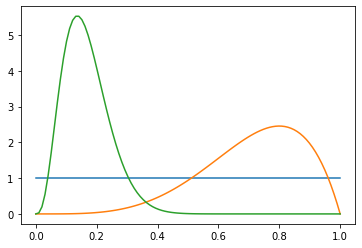

In [83]:
q_plot = np.linspace(0,1,100)
AlphaBetas = [(1,1),(5,2),(4,20)]

for alpha,beta in AlphaBetas:
    pdf = st.beta.pdf(q_plot,alpha,beta)
    plt.plot(q_plot,pdf)

The Beta  distrubtion is supported on $[0,1]$ and has the density
$$
p(q|\alpha,\beta) = \frac{1}{B(\alpha,\beta)}q^{\alpha-1}(1-q)^{\beta -1}
$$

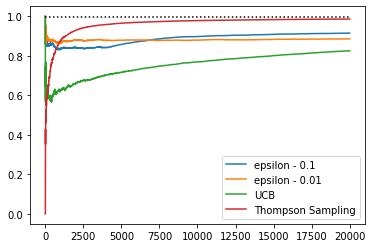

In [90]:
nQ = 100
numSteps = 20000
# Uniformly random reward distribution
q_true = rnd.rand(nQ)

# True Rewards
R_true = np.column_stack([st.bernoulli.rvs(q,size=numSteps) for q in q_true]) 

eps10 = epsGreedyAgent(nQ,0.1,label='epsilon - 0.1') 
eps01 = epsGreedyAgent(nQ,0.01,label='epsilon - 0.01')
ucb = ucbAgent(nQ)
thompson = tsAgent(nQ)

Agents = [eps10,eps01,ucb,thompson]

for agent in Agents:
    Rewards = []
    for step in range(numSteps):
        a = agent.action()
        r = R_true[step,a]
        agent.update(a,r)
        Rewards.append(r)
        
    plt.plot(np.cumsum(Rewards)/(1+np.arange(numSteps)),label=agent.label)
    
plt.legend()
plt.plot([0,numSteps-1],np.max(q_true)*np.ones(2),'k:')